# Imports

In [144]:
import pandas as pd
from collections import Counter
import string

import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [71]:
COLOR = '#62d197'

# EDA

In [77]:
data = pd.read_csv('../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [3]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns')

This dataset has 1050 rows and 15 columns


## Duplicates

In [4]:
# Check for duplicates on uniq_id
duplicates = df.duplicated(subset='uniq_id')
print(f'This dataset has {duplicates.sum()} duplicates')

This dataset has 0 duplicates


## Missing values

In [5]:
# Get missing values
missing = df.isnull().sum()
print(f'This dataset has {missing.sum()} missing')
brands_missing = df['brand'].isnull().sum()
print(f'{brands_missing} missing values in the brand column')
retail_missing = df['retail_price'].isnull().sum()
print(f'{retail_missing} missing value in the retail_price column')
discount_missing = df['discounted_price'].isnull().sum()
print(f'{discount_missing} missing value in the discounted_price column')

This dataset has 341 missing
338 missing values in the brand column
1 missing value in the retail_price column
1 missing value in the discounted_price column


## Features selection

The objective is to suggest a classification in the appropriate category(ies) based on a product description and/or a product image. We will select the features according to this objective.

In [81]:
# Filter information
to_keep = ['uniq_id', 'product_name', 'product_category_tree', 'description', 'image']
print('As our goal is to create a classifier, we will keep only the following columns:')
for col in to_keep:
    print(f' - {col}')

As our goal is to create a classifier, we will keep only the following columns:
 - uniq_id
 - product_name
 - product_category_tree
 - description
 - image


In [82]:
df = df[to_keep]

## Category tree structure

In [83]:
# Get informations about category tree
df['product_category_tree'].apply(lambda x: x.split('>>')[0].replace('["','').replace(']','').strip()).value_counts()


product_category_tree
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [84]:
# Add a column main_category
df['main_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].replace('["','').replace(']','').strip())
df.head()

,uniq_id,product_name,product_category_tree,description,image,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


### Tree deepness

In [136]:
df_cat = df.copy()

def split_subcategories(product):
    cleaned = product.strip('["]').replace(' >> ', '>>')
    categories = cleaned.split('>>')
    return categories[:-1]

def extract_subcategories(row):
    categories = row.strip('["]').split(' >> ')
    sub_categories = ' '.join(categories[1:])  # Joindre toutes les sous-catégories en une seule chaîne
    return sub_categories

In [89]:
df_cat['subcategories'] = df_cat['product_category_tree'].apply(split_subcategories)
deep_max = max(df_cat['subcategories'].apply(len))
print(f'The maximum number of subcategories is {deep_max}')

for i in range(1, deep_max+1):
    df_cat[f'subcategory_{i}'] = df_cat['subcategories'].apply(lambda x: x[i] if i < len(x) else None)

df_cat.drop(columns=['product_category_tree', 'subcategories'], inplace=True)
df_cat.head()

The maximum number of subcategories is 6


,uniq_id,product_name,description,image,main_category,subcategory_1,subcategory_2,subcategory_3,subcategory_4,subcategory_5,subcategory_6
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories,Curtains,None,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,None,None,None
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,None,None,None
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,None,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,None,None,None


In [113]:
categories = df['main_category'].unique()
for cat in categories:
    df_home_frunishing = df[df['main_category'] == cat]
    subcat = len(df_home_frunishing.apply(lambda x: x['product_category_tree'].split('>>')[1], axis=1).unique())
    print(f'{cat} has {subcat} sub categories')

Home Furnishing has 12 sub categories
Baby Care has 9 sub categories
Watches has 2 sub categories
Home Decor & Festive Needs has 10 sub categories
Kitchen & Dining has 11 sub categories
Beauty and Personal Care has 11 sub categories
Computers has 8 sub categories


In [133]:
# group by main category and get the number of unique subcategories
df_cat_grouped = df_cat.groupby(['main_category'])[['subcategory_1', 'subcategory_2','subcategory_3','subcategory_4','subcategory_5','subcategory_6']].nunique().reset_index()
df_cat_grouped.head(10)

,main_category,subcategory_1,subcategory_2,subcategory_3,subcategory_4,subcategory_5,subcategory_6
0,Baby Care,9,25,36,39,46,0
1,Beauty and Personal Care,11,25,34,15,1,0
2,Computers,8,19,19,1,0,0
3,Home Decor & Festive Needs,9,25,33,8,0,0
4,Home Furnishing,11,16,10,0,0,0
5,Kitchen & Dining,11,25,28,13,0,0
6,Watches,2,8,1,0,0,0


In [134]:
df_cat.drop(columns=['subcategory_6'], inplace=True)

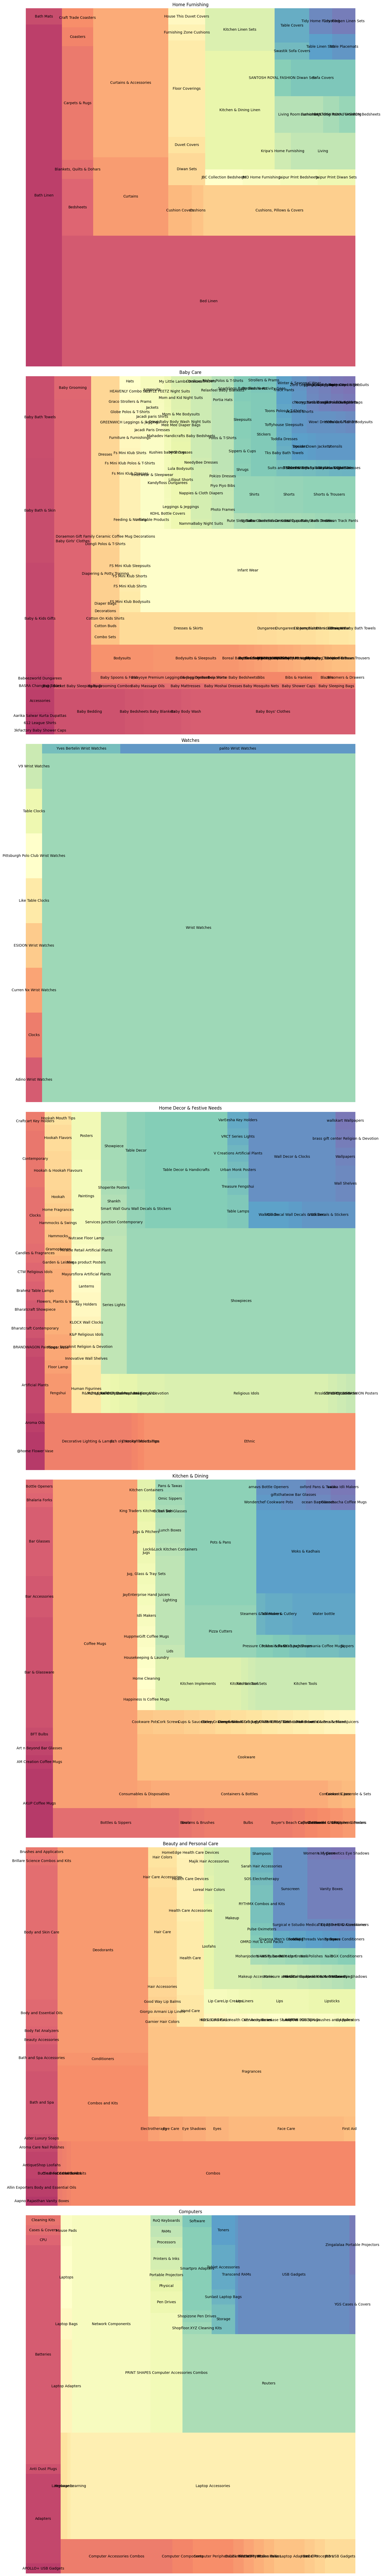

In [135]:
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 100))

for i, cat in enumerate(categories):
    filtered_df = df_cat[df_cat['main_category'] == cat]

    # Count each subcategory occurence for the category
    subcategory_count = filtered_df.filter(like='subcategory_').apply(pd.Series.value_counts).sum(axis=1)

    # Create a dataframe for the subcategories and their count
    subcategories_df = pd.DataFrame({'subcategory': subcategory_count.index, 'count': subcategory_count.values})

    # plot the tree
    squarify.plot(
        sizes=subcategories_df['count'],
        label=subcategories_df['subcategory'],
        alpha=.8,
        color=sns.color_palette("Spectral", len(subcategories_df['count'])),
        ax=axes[i],
        text_kwargs = {'fontsize': 10, 'color': 'black'},
        )
    axes[i].set_title(cat)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This tree map shows that the categories lack of homogeneity. They each have more a less children subcategories

In [137]:
df['children'] = df['product_category_tree'].apply(extract_subcategories)
df.head()

,uniq_id,product_name,product_category_tree,description,image,main_category,children
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories Curtains Elegance Polye...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin Baby Bath Towels Sathiyas Bab...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin Baby Bath Towels Eurospa Baby...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen Bedsheets SANTOSH ROYAL FASHION Beds...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen Bedsheets Jaipur Print Bedsheets Jai...


In [138]:
# drop tree column
df = df.drop(columns='product_category_tree')

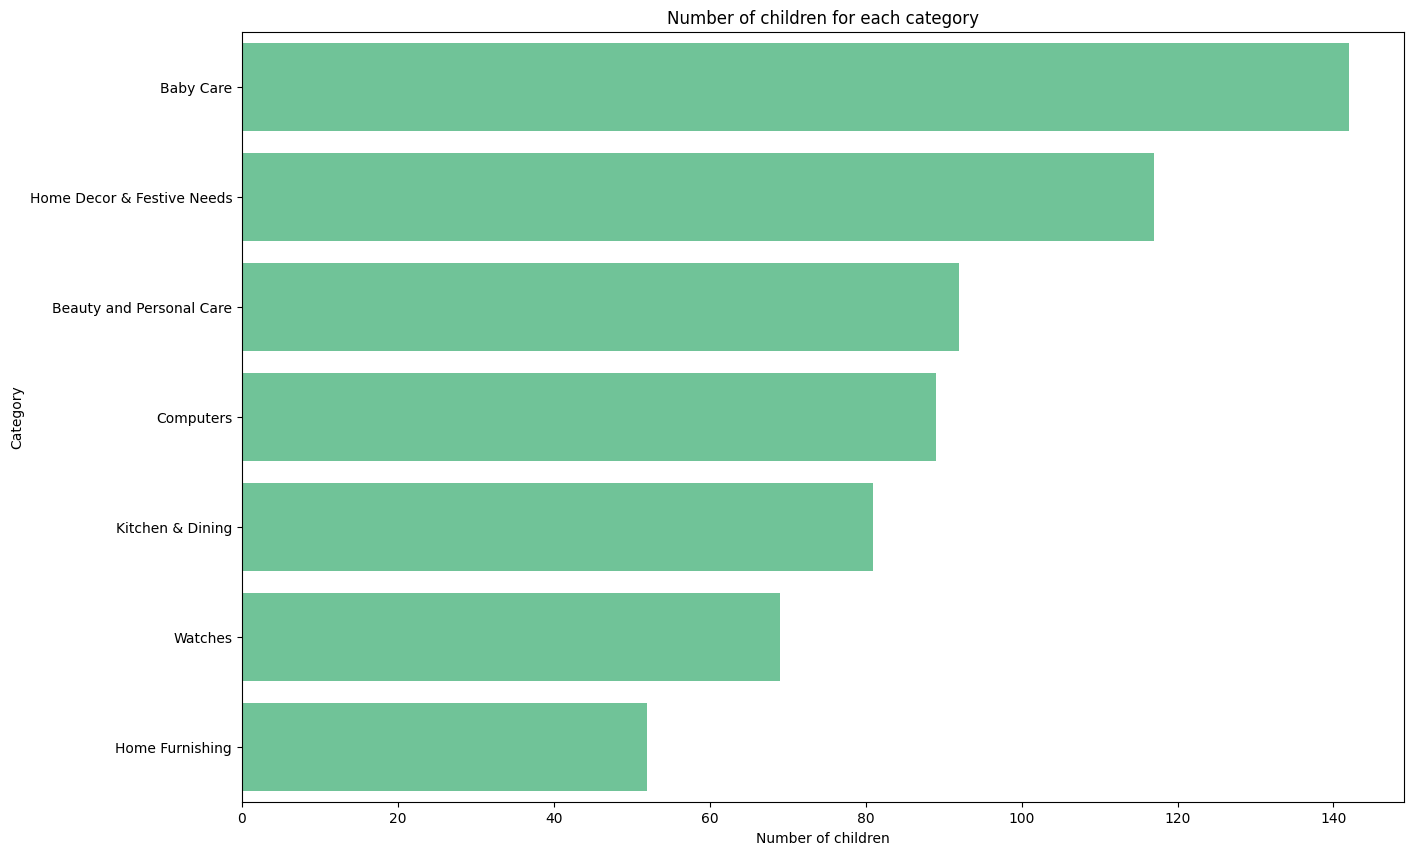

In [142]:
# Plot the number of children for each category
df_grouped = df.groupby('main_category')['children'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x=df_grouped.values, y=df_grouped.index, color=COLOR)
plt.title('Number of children for each category')
plt.xlabel('Number of children')
plt.ylabel('Category')
plt.show()


## Product description

In [157]:
# Normalize description to lowercase
df['description'] = df['description'].str.lower()

In [158]:
# Count number of characters in description
df['description_length'] = df['description'].apply(lambda x: len(x))
df['description_length'].describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description_length, dtype: float64

In [159]:
# How many sentences in a description.
# A sentence starts with a capital letter and ends with a dot.
df['description_sentences'] = df['description'].apply(lambda x: len(x.split('.')))
df['description_sentences'].describe()

count    1050.000000
mean        6.604762
std         4.655836
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        44.000000
Name: description_sentences, dtype: float64

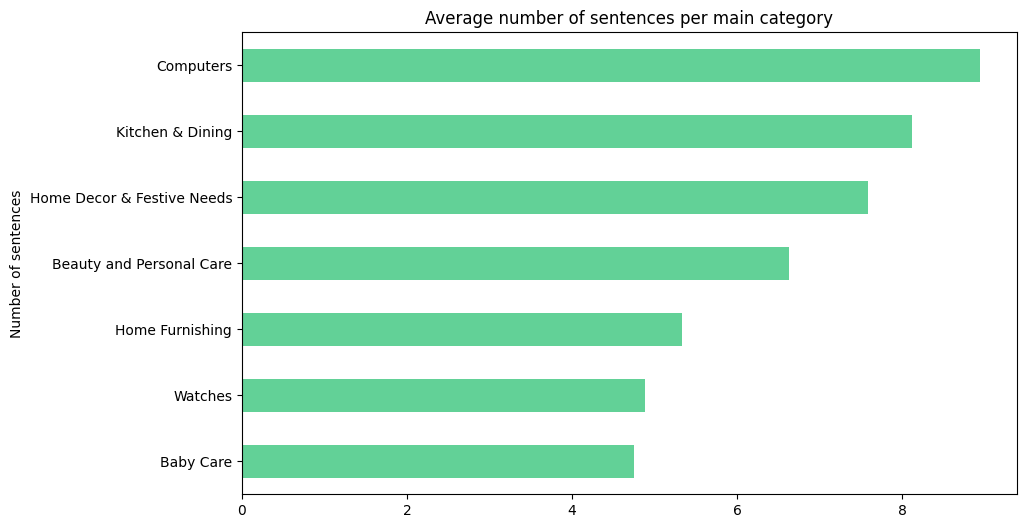

In [160]:
# plot the distribution of the number of sentences per main category ordered by the average number of sentences
# labels should be on the y-axis, and the number of sentences on the x-axis
fig = plt.figure(figsize=(10, 6))
df.groupby('main_category')['description_sentences'].mean().sort_values().plot(kind='barh', color=COLOR)
plt.title('Average number of sentences per main category')
plt.ylabel('Number of sentences')
plt.show()

In [27]:
home = df[df['main_category'] == 'Home Furnishing']


,uniq_id,product_name,product_category_tree,description,image,main_category,description_length,description_sentences
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,1420,11
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,858,1
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,1197,6
33,b85f8843bb1c297dd5712f0bd287006d,SANTOSH ROYAL FASHION Cotton Embroidered Diwan...,"[""Home Furnishing >> Living Room Furnishing >>...",Key Features of SANTOSH ROYAL FASHION Cotton E...,b85f8843bb1c297dd5712f0bd287006d.jpg,Home Furnishing,954,4
34,a4b09aa7927c59fbb39960b3d7919909,House This Queen Cotton Duvet Cover,"[""Home Furnishing >> Bed Linen >> Duvet Covers...",Key Features of House This Queen Cotton Duvet ...,a4b09aa7927c59fbb39960b3d7919909.jpg,Home Furnishing,583,2


### WordCloud

In [161]:
# Count the number of tokens in the description
tokens_count = {}
tokens_frequency = {}
# Using regex to exclude numbers and punctuation
tokenizer = RegexpTokenizer(r'\b\w*[a-zA-Z]+\w*\b|\b[a-zA-Z]+\b')

for _, row in df.iterrows():
    category = row['main_category']
    description = row['description']

    tokens = tokenizer.tokenize(description)

    if category not in tokens_count:
        tokens_count[category] = 0
    tokens_count[category] += len(tokens)

    if category not in tokens_frequency:
        tokens_frequency[category] = {}

    for token in tokens:
        if token not in tokens_frequency[category]:
            tokens_frequency[category][token] = 0
        tokens_frequency[category][token] += 1

# Create a dataframe for the tokens frequency
frequencies = []
for category, tokens in tokens_frequency.items():
    for token, freq in tokens.items():
        frequencies.append({'category':category, 'token':token, 'frequency':freq})

tokens_df = pd.DataFrame(frequencies)
token_count_df = pd.DataFrame(list(tokens_count.items()), columns=['category', 'total_tokens'])

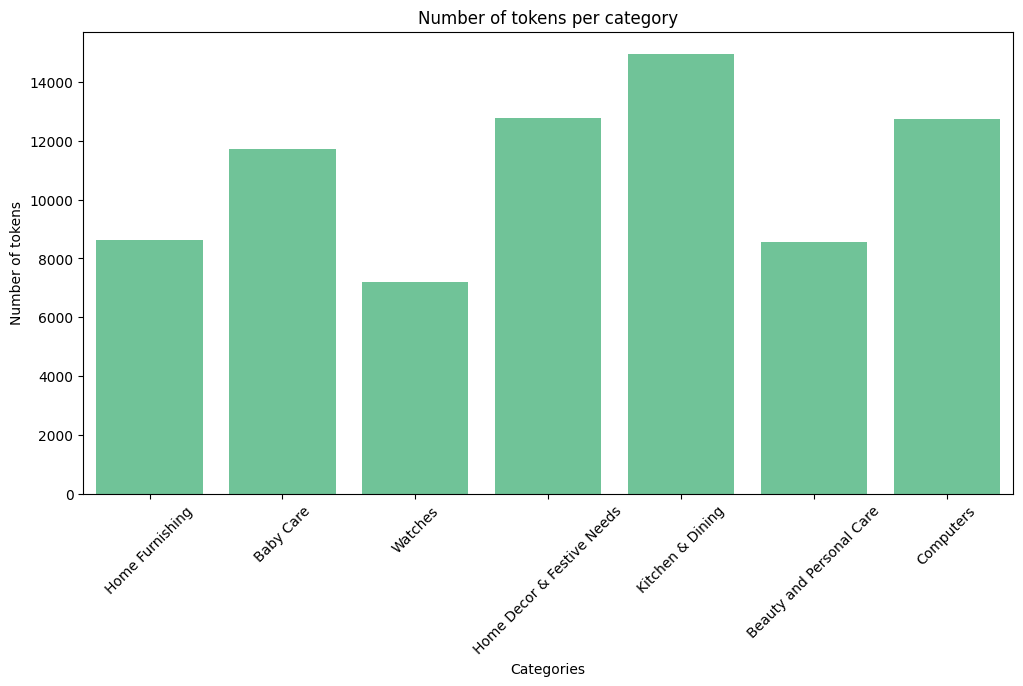

In [162]:
# Plot the number of tokens per category
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='total_tokens', data=token_count_df, color=COLOR)
plt.xticks(rotation=45)
plt.title('Number of tokens per category')
plt.xlabel('Categories')
plt.ylabel('Number of tokens')
plt.show()

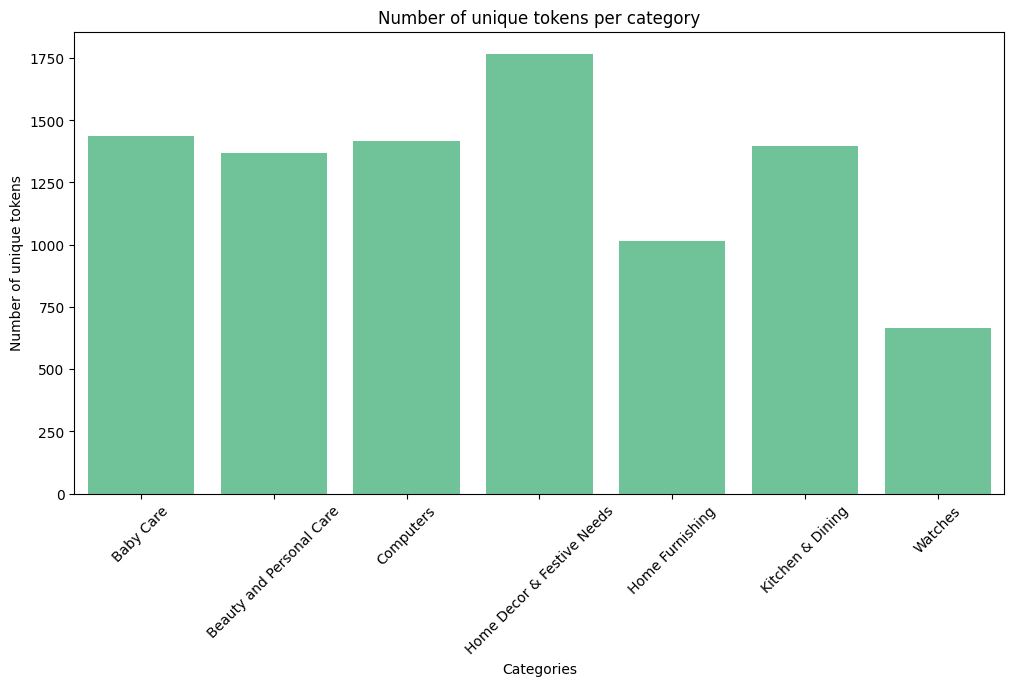

In [163]:
# Group by category to get the unique number of tokens
unique_tokens_count = tokens_df.groupby('category')['token'].count().reset_index()

# Plot the number of unique tokens per category
plt.figure(figsize=(12, 6))
sns.barplot(data=unique_tokens_count, x='category', y='token', color=COLOR)
plt.xticks(rotation=45)
plt.title('Number of unique tokens per category')
plt.xlabel('Categories')
plt.ylabel('Number of unique tokens')
plt.show()

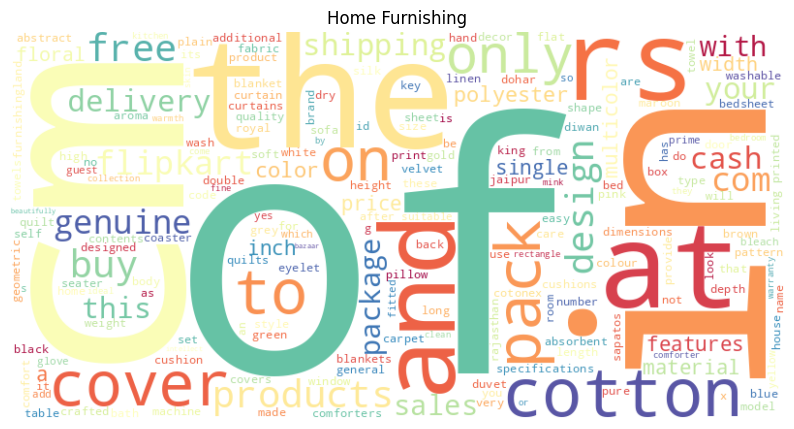

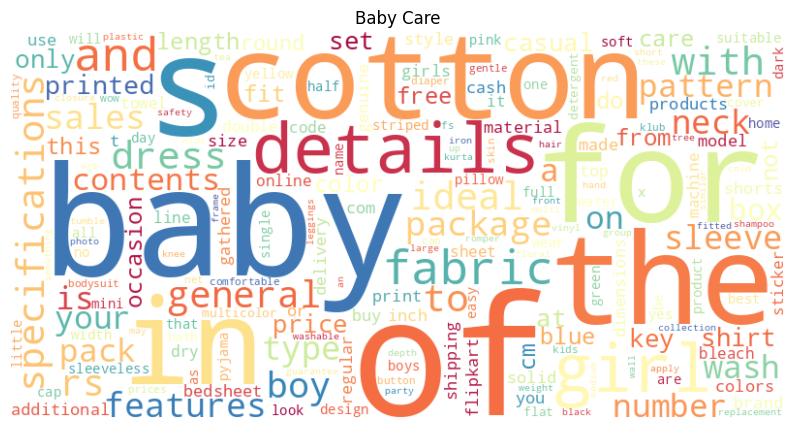

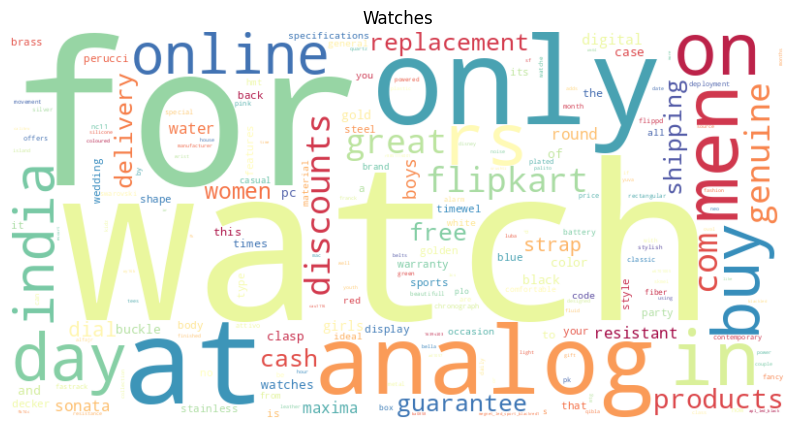

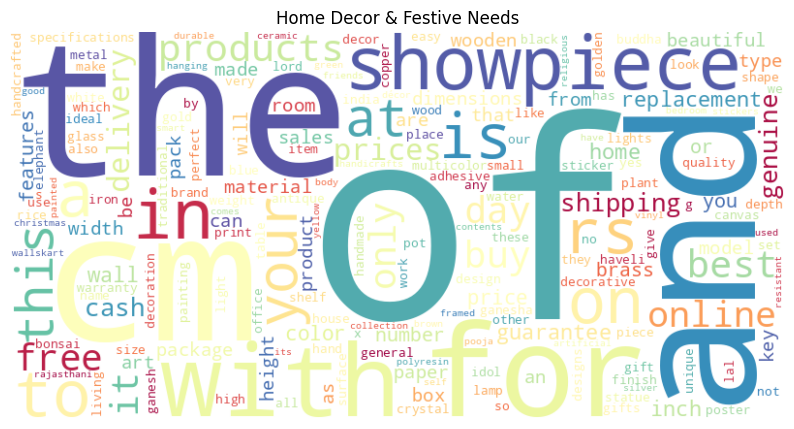

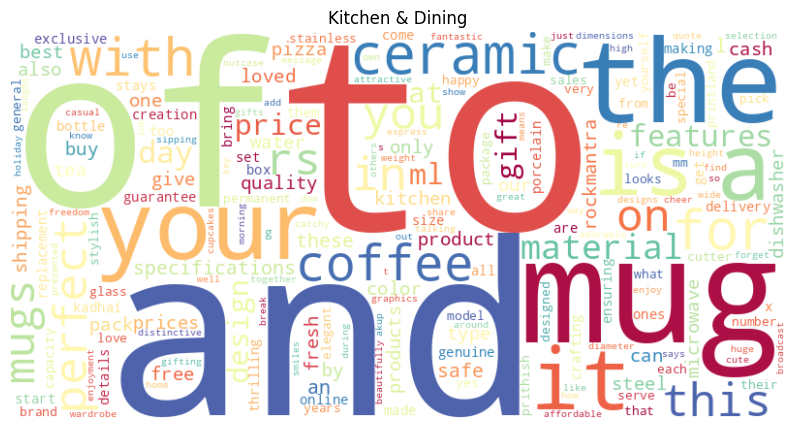

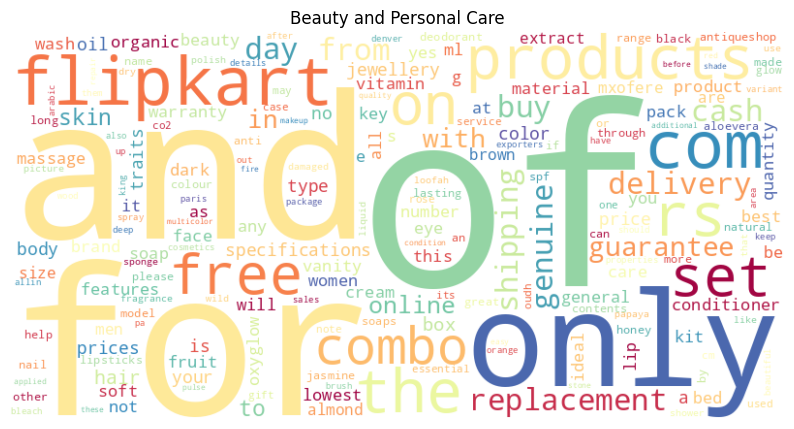

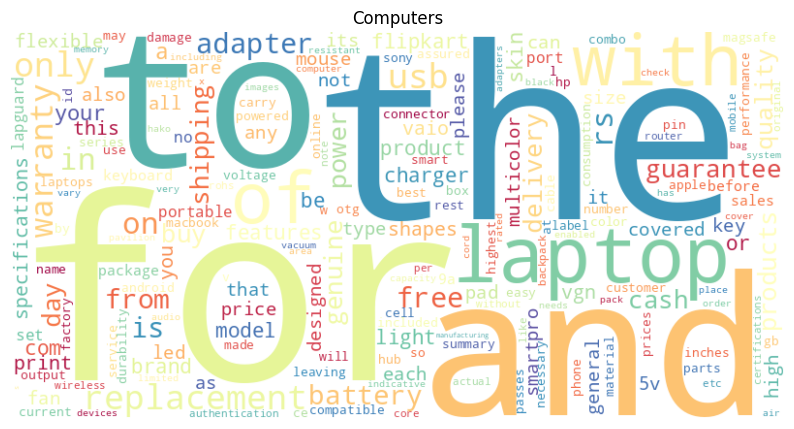

In [164]:
# Plot the WordCloud for each category
for category in tokens_df['category'].unique():
    # Filter on current category
    category_df = tokens_df[tokens_df['category'] == category]

    # Make a dictionnary of words frequency
    token_dict = dict(zip(category_df['token'], category_df['frequency']))

    # Instanciate the WordCloud
    wc = WordCloud(background_color='white', width=800, height=400, colormap='Spectral')
    wc.generate_from_frequencies(token_dict)

    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()

# TEXT PRE-PROCESSING

In [175]:
tokens_number = len(tokens_df['token'].unique())
print(f'There are {tokens_number} unique tokens in the dataset')

There are 5516 unique tokens in the dataset


In [168]:
# Get rid of stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
# Get unique tokens per category
tokens_per_category = tokens_df.groupby('category')['token'].unique().reset_index()
tokens_per_category

,category,token
0,Baby Care,"[specifications, of, sathiyas, cotton, bath, t..."
1,Beauty and Personal Care,"[key, features, of, burt, s, bees, hair, repai..."
2,Computers,"[key, features, of, d, link, dap1320, qrs, app..."
3,Home Decor & Festive Needs,"[myesquire, ceramic, burner, pot, lemongrass, ..."
4,Home Furnishing,"[key, features, of, elegance, polyester, multi..."
5,Kitchen & Dining,"[key, features, of, dungri, india, craft, ducj..."
6,Watches,"[maserati, time, r8851116001, analog, watch, f..."


In [173]:
# Remove stopwords from the tokens
tokens_per_category['filtered_token'] = tokens_per_category['token'].apply(lambda x: [token for token in x if token.lower() not in stopwords])
tokens_per_category

,category,token,filtered_token
0,Baby Care,"[specifications, of, sathiyas, cotton, bath, t...","[specifications, sathiyas, cotton, bath, towel..."
1,Beauty and Personal Care,"[key, features, of, burt, s, bees, hair, repai...","[key, features, burt, bees, hair, repair, shea..."
2,Computers,"[key, features, of, d, link, dap1320, qrs, app...","[key, features, link, dap1320, qrs, app, ios, ..."
3,Home Decor & Festive Needs,"[myesquire, ceramic, burner, pot, lemongrass, ...","[myesquire, ceramic, burner, pot, lemongrass, ..."
4,Home Furnishing,"[key, features, of, elegance, polyester, multi...","[key, features, elegance, polyester, multicolo..."
5,Kitchen & Dining,"[key, features, of, dungri, india, craft, ducj...","[key, features, dungri, india, craft, ducjug01..."
6,Watches,"[maserati, time, r8851116001, analog, watch, f...","[maserati, time, r8851116001, analog, watch, b..."


In [174]:
# Find back the frequency of filtered tokens
filtered_token_frequency = tokens_df[tokens_df['token'].isin(tokens_per_category['filtered_token'].explode())]
filtered_token_frequency

,category,token,frequency
0,Home Furnishing,key,32
1,Home Furnishing,features,55
3,Home Furnishing,elegance,5
4,Home Furnishing,polyester,61
5,Home Furnishing,multicolor,54
...,...,...,...
9060,Computers,feather,4
9061,Computers,despicable,4
9063,Computers,looking,4
9064,Computers,upwards,4


In [176]:
filtered_tokens_number = len(filtered_token_frequency['token'].unique())
difference = tokens_number - filtered_tokens_number
print(f'There are {filtered_tokens_number} unique tokens in the dataset after removing stopwords')
print(f'The difference is {difference} tokens')

There are 5397 unique tokens in the dataset after removing stopwords
The difference is 119 tokens
